In [1]:
# Optional step! Ignore if already installed.
!pip install opendatasets

In [2]:
import opendatasets as open

open.download('https://www.kaggle.com/soumikrakshit/anime-faces')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sunritjana
Your Kaggle Key: ··········


  0%|          | 0.00/441M [00:00<?, ?B/s]

100%|██████████| 441M/441M [00:13<00:00, 34.7MB/s]


In [3]:
import os

DATA_DIR = 'anime-faces'

# Get all the files downloaded
print(os.listdir(DATA_DIR))

['data']


In [4]:
print(os.listdir(f"{DATA_DIR}/data")[:5])

['12016.png', '19916.png', '11247.png', '7516.png', '18874.png']


In [5]:
# Import the loaders in pytorch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

# Important variables.
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Loading the data.
train_ds = ImageFolder(
    DATA_DIR,
    transform=T.Compose([
      T.Resize(image_size),
      T.CenterCrop(image_size),
      T.ToTensor(),
      T.Normalize(*stats)
    ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

%matplotlib inline

In [7]:
# To show the images
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

# Using show_images, Display a batch of the training images
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

# Denormalization script for the image grid, which is stored in the form of a tensor.
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


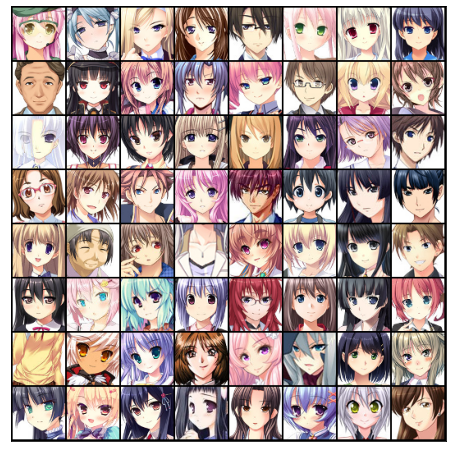

In [8]:
show_batch(train_dl)

In [9]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Basically the loader for the device for training. Supported ones: CPU, GPU (Needs CUDA Enabled)

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [11]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

print(f"Device used: {device}")

Device used: cuda


In [12]:
import torch.nn as nn

In [13]:
latent_size = 128

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)


In [14]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

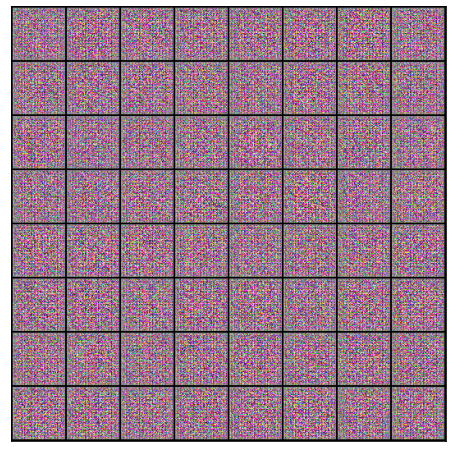

In [15]:
# Convert to device
discriminator = to_device(discriminator, device)

# Generate the fake images
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)

# Convert gen to device too.
generator = to_device(generator, device)

show_images(fake_images)

In [16]:
def train_generator(opt_g):
    opt_g.zero_grad()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_g.step()
  
    return loss.item()

def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
  
    return loss.item(), real_score, fake_score

In [17]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
# TRAINING TIME!
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g, losses_d = [], []
    real_scores, fake_scores = [], []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch + start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [21]:
EPOCHS = 60
LR = 0.001

history = fit(EPOCHS, LR)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/60], loss_g: 5.1065, loss_d: 1.2260, real_score: 0.3771, fake_score: 0.0054
Saving generated-images-0001.png



Epoch [2/60], loss_g: 3.2624, loss_d: 1.2491, real_score: 0.3831, fake_score: 0.0197
Saving generated-images-0002.png



Epoch [3/60], loss_g: 6.8159, loss_d: 0.8455, real_score: 0.8751, fake_score: 0.4459
Saving generated-images-0003.png



Epoch [4/60], loss_g: 2.0812, loss_d: 1.3567, real_score: 0.3822, fake_score: 0.0293
Saving generated-images-0004.png



Epoch [5/60], loss_g: 8.4067, loss_d: 0.7753, real_score: 0.9119, fake_score: 0.4146
Saving generated-images-0005.png



Epoch [6/60], loss_g: 4.2970, loss_d: 0.3420, real_score: 0.9628, fake_score: 0.2004
Saving generated-images-0006.png



Epoch [7/60], loss_g: 9.6698, loss_d: 0.5890, real_score: 0.9788, fake_score: 0.3887
Saving generated-images-0007.png



Epoch [8/60], loss_g: 6.5304, loss_d: 0.3774, real_score: 0.9333, fake_score: 0.2239
Saving generated-images-0008.png



Epoch [9/60], loss_g: 5.2131, loss_d: 0.3979, real_score: 0.8536, fake_score: 0.1659
Saving generated-images-0009.png



Epoch [10/60], loss_g: 4.4220, loss_d: 0.3252, real_score: 0.8646, fake_score: 0.1165
Saving generated-images-0010.png



Epoch [11/60], loss_g: 3.0641, loss_d: 0.4155, real_score: 0.7441, fake_score: 0.0238
Saving generated-images-0011.png



Epoch [12/60], loss_g: 8.5191, loss_d: 0.6016, real_score: 0.9952, fake_score: 0.3726
Saving generated-images-0012.png



Epoch [13/60], loss_g: 5.3243, loss_d: 0.1823, real_score: 0.9431, fake_score: 0.1044
Saving generated-images-0013.png



Epoch [14/60], loss_g: 3.2643, loss_d: 0.2990, real_score: 0.8380, fake_score: 0.0725
Saving generated-images-0014.png



Epoch [15/60], loss_g: 8.9791, loss_d: 0.9489, real_score: 0.9975, fake_score: 0.4906
Saving generated-images-0015.png



Epoch [16/60], loss_g: 4.0782, loss_d: 0.1304, real_score: 0.9305, fake_score: 0.0498
Saving generated-images-0016.png



Epoch [17/60], loss_g: 5.6390, loss_d: 0.1082, real_score: 0.9478, fake_score: 0.0447
Saving generated-images-0017.png



Epoch [18/60], loss_g: 8.6245, loss_d: 1.4488, real_score: 0.9989, fake_score: 0.6336
Saving generated-images-0018.png



Epoch [19/60], loss_g: 5.5660, loss_d: 0.2642, real_score: 0.9550, fake_score: 0.1642
Saving generated-images-0019.png



Epoch [20/60], loss_g: 1.9458, loss_d: 1.4854, real_score: 0.4310, fake_score: 0.0438
Saving generated-images-0020.png



Epoch [21/60], loss_g: 3.5333, loss_d: 0.2085, real_score: 0.8806, fake_score: 0.0533
Saving generated-images-0021.png



Epoch [22/60], loss_g: 3.6921, loss_d: 0.9064, real_score: 0.5362, fake_score: 0.0033
Saving generated-images-0022.png



Epoch [23/60], loss_g: 3.0374, loss_d: 0.3206, real_score: 0.7663, fake_score: 0.0053
Saving generated-images-0023.png



Epoch [24/60], loss_g: 4.1357, loss_d: 0.0905, real_score: 0.9746, fake_score: 0.0559
Saving generated-images-0024.png



Epoch [25/60], loss_g: 5.2273, loss_d: 0.0984, real_score: 0.9709, fake_score: 0.0592
Saving generated-images-0025.png



Epoch [26/60], loss_g: 5.7601, loss_d: 0.1077, real_score: 0.9751, fake_score: 0.0678
Saving generated-images-0026.png



Epoch [27/60], loss_g: 6.5002, loss_d: 0.1157, real_score: 0.9809, fake_score: 0.0809
Saving generated-images-0027.png



Epoch [28/60], loss_g: 4.6719, loss_d: 0.1225, real_score: 0.9056, fake_score: 0.0136
Saving generated-images-0028.png



Epoch [29/60], loss_g: 5.2579, loss_d: 0.1136, real_score: 0.9838, fake_score: 0.0860
Saving generated-images-0029.png



Epoch [30/60], loss_g: 5.2410, loss_d: 0.1201, real_score: 0.9667, fake_score: 0.0750
Saving generated-images-0030.png



Epoch [31/60], loss_g: 13.7966, loss_d: 2.6757, real_score: 0.9892, fake_score: 0.7757
Saving generated-images-0031.png



Epoch [32/60], loss_g: 6.2617, loss_d: 0.0468, real_score: 0.9760, fake_score: 0.0200
Saving generated-images-0032.png



Epoch [33/60], loss_g: 5.6877, loss_d: 0.0707, real_score: 0.9765, fake_score: 0.0363
Saving generated-images-0033.png



Epoch [34/60], loss_g: 5.5599, loss_d: 0.1307, real_score: 0.9742, fake_score: 0.0833
Saving generated-images-0034.png



Epoch [35/60], loss_g: 6.3653, loss_d: 0.0461, real_score: 0.9649, fake_score: 0.0084
Saving generated-images-0035.png



Epoch [36/60], loss_g: 5.9606, loss_d: 0.3001, real_score: 0.9372, fake_score: 0.1381
Saving generated-images-0036.png



Epoch [37/60], loss_g: 5.6485, loss_d: 0.0459, real_score: 0.9649, fake_score: 0.0087
Saving generated-images-0037.png



Epoch [38/60], loss_g: 5.3912, loss_d: 0.0516, real_score: 0.9858, fake_score: 0.0321
Saving generated-images-0038.png



Epoch [39/60], loss_g: 4.3593, loss_d: 0.1815, real_score: 0.9124, fake_score: 0.0453
Saving generated-images-0039.png



Epoch [40/60], loss_g: 5.8736, loss_d: 0.0236, real_score: 0.9928, fake_score: 0.0159
Saving generated-images-0040.png



Epoch [41/60], loss_g: 7.9609, loss_d: 0.5578, real_score: 0.6704, fake_score: 0.0002
Saving generated-images-0041.png



Epoch [42/60], loss_g: 5.3136, loss_d: 0.0630, real_score: 0.9859, fake_score: 0.0345
Saving generated-images-0042.png



Epoch [43/60], loss_g: 4.2156, loss_d: 0.1548, real_score: 0.9747, fake_score: 0.0847
Saving generated-images-0043.png



Epoch [44/60], loss_g: 5.6534, loss_d: 0.7700, real_score: 0.9444, fake_score: 0.3962
Saving generated-images-0044.png



Epoch [45/60], loss_g: 3.9029, loss_d: 0.1800, real_score: 0.9049, fake_score: 0.0518
Saving generated-images-0045.png



Epoch [46/60], loss_g: 6.9557, loss_d: 0.0428, real_score: 0.9906, fake_score: 0.0301
Saving generated-images-0046.png



Epoch [47/60], loss_g: 5.4161, loss_d: 0.2479, real_score: 0.8615, fake_score: 0.0370
Saving generated-images-0047.png



Epoch [48/60], loss_g: 4.4358, loss_d: 0.0648, real_score: 0.9652, fake_score: 0.0258
Saving generated-images-0048.png



Epoch [49/60], loss_g: 4.6309, loss_d: 0.9809, real_score: 0.8474, fake_score: 0.3689
Saving generated-images-0049.png



Epoch [50/60], loss_g: 6.8145, loss_d: 0.2139, real_score: 0.9743, fake_score: 0.1291
Saving generated-images-0050.png



Epoch [51/60], loss_g: 5.5581, loss_d: 0.0246, real_score: 0.9847, fake_score: 0.0088
Saving generated-images-0051.png



Epoch [52/60], loss_g: 6.6736, loss_d: 0.2591, real_score: 0.9281, fake_score: 0.0964
Saving generated-images-0052.png



Epoch [53/60], loss_g: 3.3859, loss_d: 0.2473, real_score: 0.8671, fake_score: 0.0250
Saving generated-images-0053.png



Epoch [54/60], loss_g: 6.3900, loss_d: 0.0404, real_score: 0.9936, fake_score: 0.0313
Saving generated-images-0054.png



Epoch [55/60], loss_g: 5.8781, loss_d: 0.1168, real_score: 0.9212, fake_score: 0.0170
Saving generated-images-0055.png



Epoch [56/60], loss_g: 8.5840, loss_d: 0.0778, real_score: 0.9966, fake_score: 0.0622
Saving generated-images-0056.png



Epoch [57/60], loss_g: 6.6216, loss_d: 0.0410, real_score: 0.9771, fake_score: 0.0152
Saving generated-images-0057.png



Epoch [58/60], loss_g: 5.1421, loss_d: 0.0320, real_score: 0.9858, fake_score: 0.0127
Saving generated-images-0058.png



Epoch [59/60], loss_g: 6.2418, loss_d: 0.0109, real_score: 0.9977, fake_score: 0.0081
Saving generated-images-0059.png



Epoch [60/60], loss_g: 2.8941, loss_d: 0.3469, real_score: 0.7692, fake_score: 0.0007
Saving generated-images-0060.png


In [22]:
# Now save the models. It's hard to train over GPU took, Almost took me 3 hours, over NVIDIA TESLA GPU.

torch.save(generator.state_dict(), "generator_model.bin")
torch.save(discriminator.state_dict(), "discriminator_model.bin")

In [23]:
# Import Image to review the GANs
from IPython.display import Image

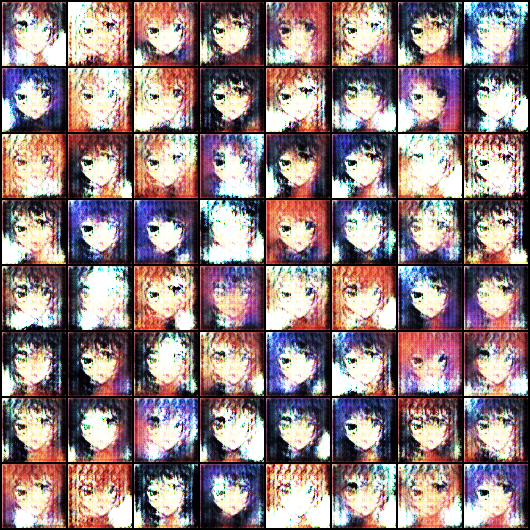

In [24]:
Image('./generated/generated-images-0001.png')

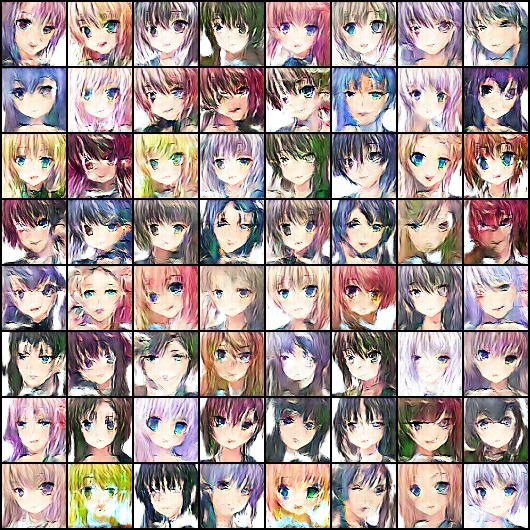

In [25]:
Image('./generated/generated-images-0010.png')

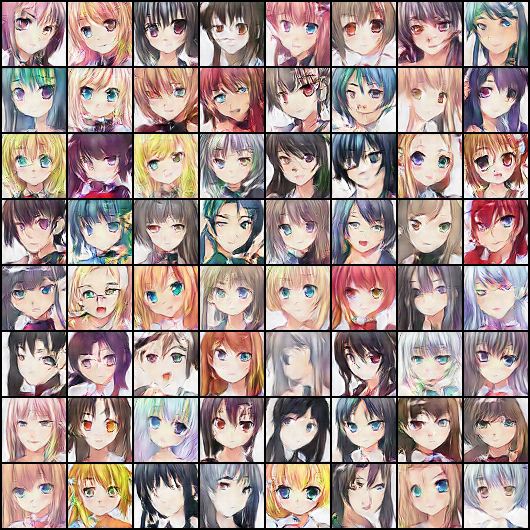

In [26]:
Image('./generated/generated-images-0020.png')

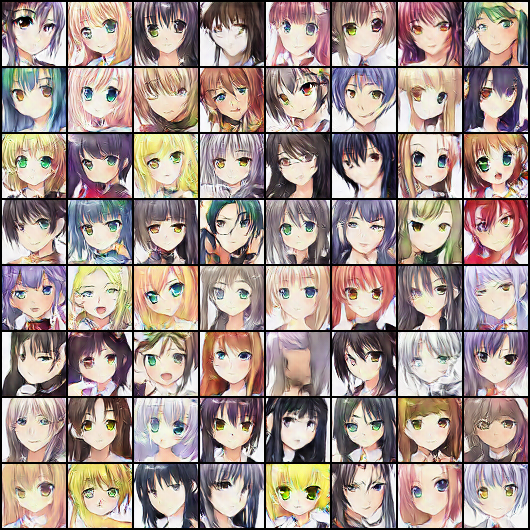

In [27]:
Image('./generated/generated-images-0040.png')

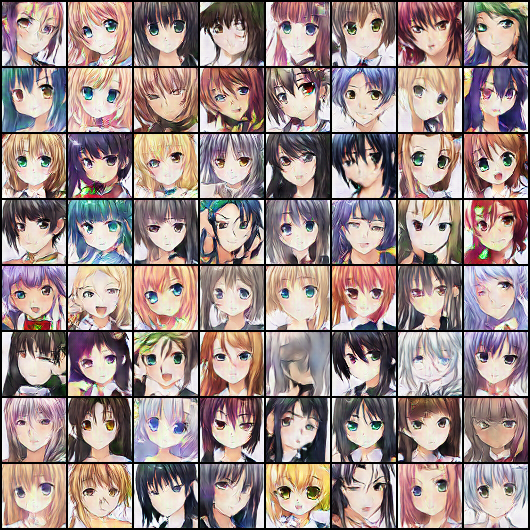

In [28]:
Image('./generated/generated-images-0060.png')

In [30]:
# Record the frames as video

import cv2
import os

def save_frames_as_video(filename, images_path):
  vid_fname = filename

  files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if images_path in f]
  files.sort()

  out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
  [out.write(cv2.imread(fname)) for fname in files]

  out.release()

save_frames_as_video("anime_face_dcgan.avi", "generated")